In [1]:
pip install ucimlrepo

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


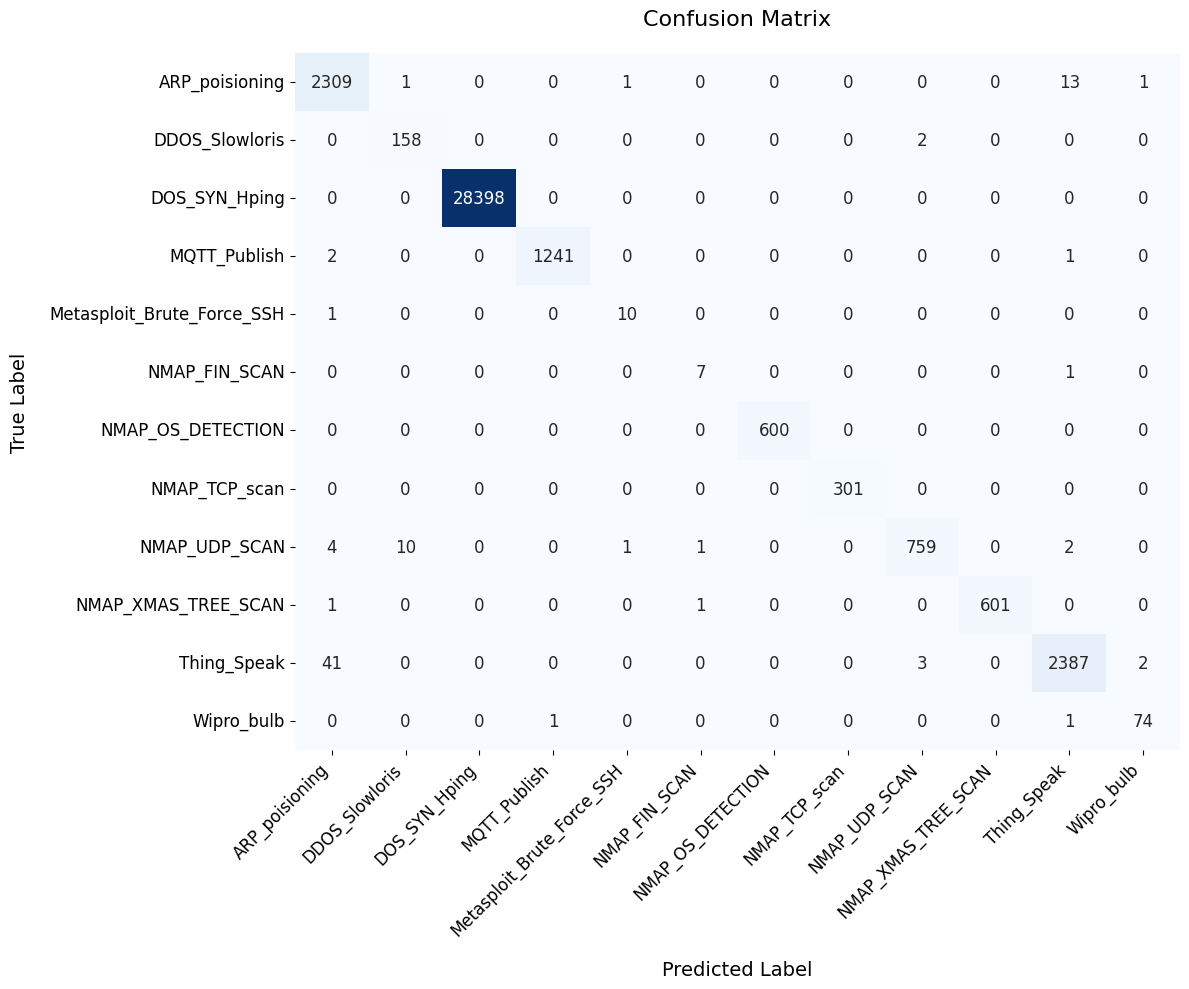

                             CLASSIFICATION REPORT                              
                            precision    recall  f1-score   support

            ARP_poisioning     0.9792    0.9931    0.9861      2325
            DDOS_Slowloris     0.9349    0.9875    0.9605       160
             DOS_SYN_Hping     1.0000    1.0000    1.0000     28398
              MQTT_Publish     0.9992    0.9976    0.9984      1244
Metasploit_Brute_Force_SSH     0.8333    0.9091    0.8696        11
             NMAP_FIN_SCAN     0.7778    0.8750    0.8235         8
         NMAP_OS_DETECTION     1.0000    1.0000    1.0000       600
             NMAP_TCP_scan     1.0000    1.0000    1.0000       301
             NMAP_UDP_SCAN     0.9935    0.9768    0.9851       777
       NMAP_XMAS_TREE_SCAN     1.0000    0.9967    0.9983       603
               Thing_Speak     0.9925    0.9811    0.9868      2433
                Wipro_bulb     0.9610    0.9737    0.9673        76

                  accuracy       

<ipython-input-4-2d4f2b894a1c>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


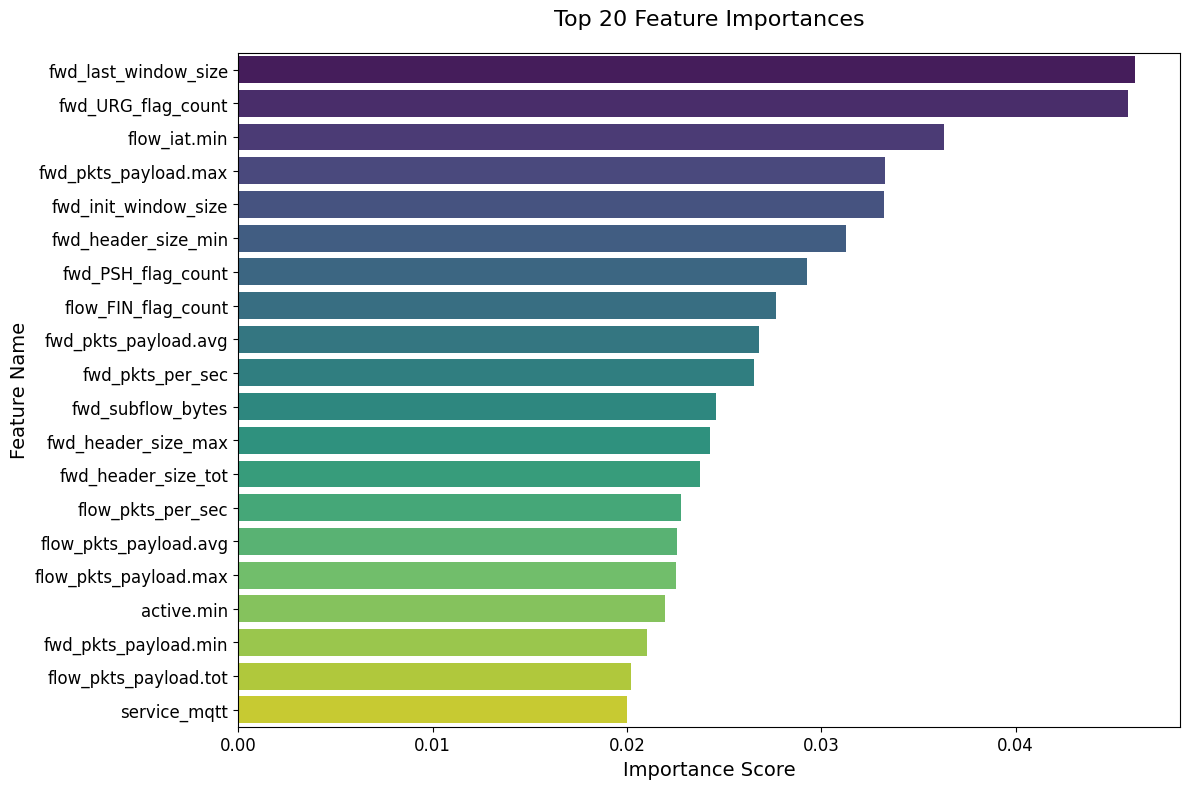


                          FEATURE IMPORTANCE ANALYSIS                           
              Feature  Importance
 fwd_last_window_size    0.046146
   fwd_URG_flag_count    0.045802
         flow_iat.min    0.036307
 fwd_pkts_payload.max    0.033264
 fwd_init_window_size    0.033205
  fwd_header_size_min    0.031259
   fwd_PSH_flag_count    0.029275
  flow_FIN_flag_count    0.027672
 fwd_pkts_payload.avg    0.026814
     fwd_pkts_per_sec    0.026537
    fwd_subflow_bytes    0.024571
  fwd_header_size_max    0.024266
  fwd_header_size_tot    0.023761
    flow_pkts_per_sec    0.022803
flow_pkts_payload.avg    0.022575
flow_pkts_payload.max    0.022516
           active.min    0.021949
 fwd_pkts_payload.min    0.021032
flow_pkts_payload.tot    0.020186
         service_mqtt    0.020022


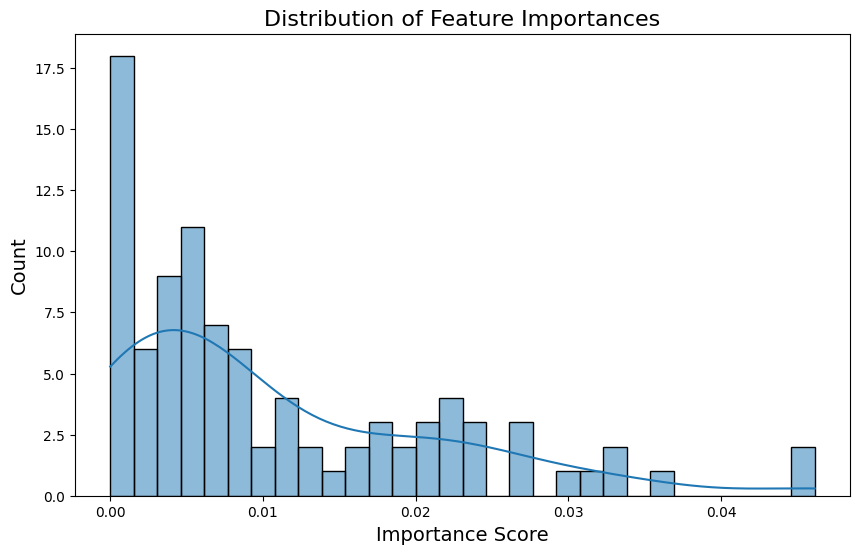

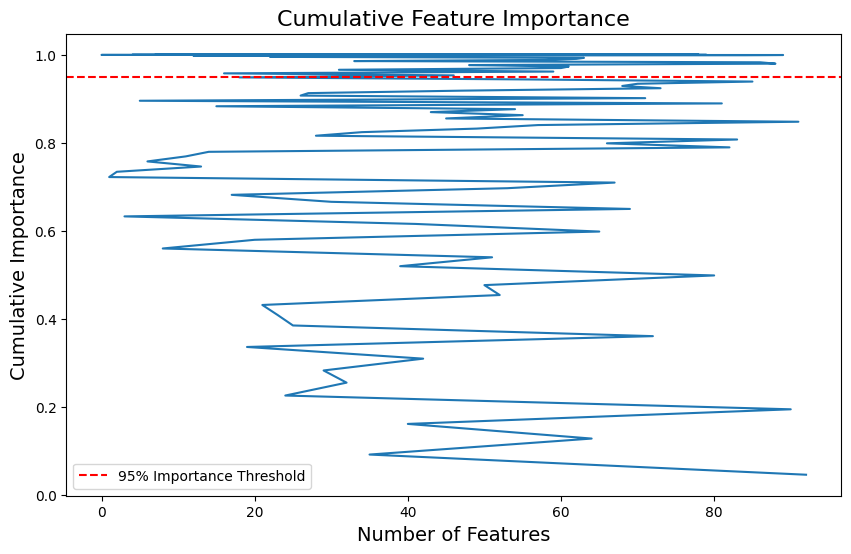

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# importing the dataset
rt_iot2022 = fetch_ucirepo(id=942)
X = rt_iot2022.data.features
y = rt_iot2022.data.targets

# Drop port-related columns
port_columns = ['src_port', 'dst_port', 'id.resp_p']
X = X.drop(columns=port_columns, errors='ignore')

# Preprocess categorical features
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)
X_processed = preprocessor.fit_transform(X)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# Generate predictions
y_pred = rf_model.predict(X_test)

# ====================
# 1. Performance Metrics
# ====================

# Professional Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes,
                cbar=False,
                annot_kws={"size": 12})
    plt.title('Confusion Matrix', pad=20, fontsize=16)
    plt.xlabel('Predicted Label', labelpad=15, fontsize=14)
    plt.ylabel('True Label', labelpad=15, fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

# Formatted Classification Report
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=np.unique(y), digits=4)
    print("="*80)
    print("CLASSIFICATION REPORT".center(80))
    print("="*80)
    print(report)
    print("="*80)

class_names = np.unique(y)
plot_confusion_matrix(y_test, y_pred, class_names)
print_classification_report(y_test, y_pred)

# FEATURE IMPORTANCE STEP
numeric_features = X.drop(columns=categorical_cols).columns.tolist()
encoded_cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = np.concatenate([encoded_cat_features, numeric_features])

# feature importance df
feature_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature',
            data=feature_importance.head(20),
            palette='viridis')
plt.title('Top 20 Feature Importances', fontsize=16, pad=20)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS".center(80))
print("="*80)
print(feature_importance.head(20).to_string(index=False))
print("="*80)

# ADVANCED ANALYSIS

# Feature Importance Distribution
plt.figure(figsize=(10, 6))
sns.histplot(feature_importance['Importance'], bins=30, kde=True)
plt.title('Distribution of Feature Importances', fontsize=16)
plt.xlabel('Importance Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Cumulative Importance
feature_importance['Cumulative'] = feature_importance['Importance'].cumsum()
plt.figure(figsize=(10, 6))
plt.plot(feature_importance['Cumulative'])
plt.title('Cumulative Feature Importance', fontsize=16)
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Cumulative Importance', fontsize=14)
plt.axhline(y=0.95, color='r', linestyle='--',
            label='95% Importance Threshold')
plt.legend()
plt.show()